### Imports

In [59]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch, K2Score

### Data Preprocessing for RecipeNLG

Loading in RecipeNLG; removing unnecessary columsn and culling down data to reasonable amount of data points to train Bayesian Network more efficiently

In [60]:
dataset_path = "recipeNLG.csv"
df = pd.read_csv(dataset_path, index_col = 0)
df = df.drop(columns=['link', 'source', 'directions'], errors='ignore')
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)

In [61]:
# Show raw dataset sample
df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2231142 entries, 0 to 2231141
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   title        object
 1   ingredients  object
 2   NER          object
dtypes: object(3)
memory usage: 68.1+ MB


In [62]:
# We need this list of measurement units for filtering (unfortunate really)
MEASUREMENT_UNITS = [
    'tsp', 'tbsp', 'c', 'cup', 'cups', 'ml', 'l', 'liters', 'liter', 'fl oz', 'fluid ounce',
    'oz', 'ounce', 'ounces', 'g', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'lb', 'pound', 'pounds',
    'piece', 'clove', 'slice', 'dash', 'pinch', 'quart', 'pint'
]
unit_pattern = re.compile(r'\b(?:' + '|'.join(MEASUREMENT_UNITS) + r')\b', re.IGNORECASE)
number_pattern = re.compile(r'(\d+(/\d+)?\s*)')

In [63]:
def extract_ingredient_data(ingredient):
    # Edge case / error handling
    if not isinstance(ingredient, str) or ingredient.strip() == "":
        return None, ""

    ingredient_lower = ingredient.lower().strip()

    amount_match = number_pattern.search(ingredient_lower)
    amount = amount_match.group(0).strip() if amount_match else "unknown"

    unit_match = unit_pattern.search(ingredient_lower)
    unit = unit_match.group(0) if unit_match else "unknown"

    cleaned_ingredient = number_pattern.sub('', ingredient_lower)
    cleaned_ingredient = unit_pattern.sub('', cleaned_ingredient)
    cleaned_ingredient = re.sub(r'[^\w\s]', '', cleaned_ingredient)
    cleaned_ingredient = cleaned_ingredient.strip()

    return cleaned_ingredient, f"{amount} {unit}"

In [64]:
def process_ingredients(ingredient_list):
    # Error case / edge case handling
    if not isinstance(ingredient_list, list) or len(ingredient_list) == 0:
        return [], []

    extracted_data = [extract_ingredient_data(ingredient) for ingredient in ingredient_list]
    cleaned, ner = zip(*extracted_data) if extracted_data else ([], [])

    cleaned = [c if c is not None else "" for c in cleaned]
    ner = [n if n is not None else "" for n in ner]

    return list(cleaned), list(ner)

Cleaning the DataFrame

In [65]:
df[['cleaned_ingredients', 'NER']] = df['ingredients'].apply(lambda lst: pd.Series(process_ingredients(lst)))
df['NER'] = df['NER'].apply(lambda x: x if isinstance(x, list) else [])
df = df[df['NER'].apply(lambda ner_list: all("unknown" not in ner for ner in ner_list))]

df = df.reset_index(drop=True)
df = df.drop(columns = ['ingredients'], errors = 'ignore')
df = df.rename(columns={'NER': 'measurements', 'cleaned_ingredients' : 'ingredients'})
df['num_ingredients'] = df['ingredients'].apply(len)

In [66]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170495 entries, 0 to 170494
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            170495 non-null  object
 1   measurements     170495 non-null  object
 2   ingredients      170495 non-null  object
 3   num_ingredients  170495 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


In [67]:
# CPT
ingredient_pairs = Counter()
for ingredients in df['ingredients']:  
    for pair in combinations(set(ingredients), 2): 
        ingredient_pairs[pair] += 1

total_pairs = sum(ingredient_pairs.values())
ingredient_co_occurrence_probs = {pair: count / total_pairs for pair, count in ingredient_pairs.items()}

top_co_occurrences = sorted(ingredient_co_occurrence_probs.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Ingredient Pair Probabilities:")
for pair, prob in top_co_occurrences:
    print(f"{pair}: {prob:.4f}")


Top 10 Ingredient Pair Probabilities:
('sugar', 'salt'): 0.0045
('sugar', 'vanilla'): 0.0031
('flour', 'salt'): 0.0030
('sugar', 'flour'): 0.0026
('sugar', 'water'): 0.0025
('salt', 'pepper'): 0.0023
('salt', 'water'): 0.0022
('salt', 'milk'): 0.0021
('sugar', 'milk'): 0.0020
('sugar', 'butter'): 0.0020


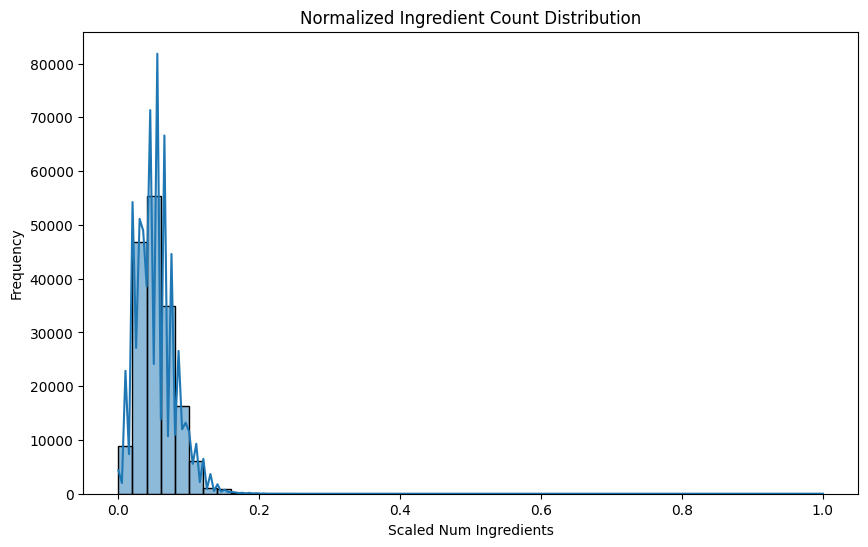

In [68]:
# Scaling to help training
scaler = MinMaxScaler()
df['num_ingredients_scaled'] = scaler.fit_transform(df[['num_ingredients']])

plt.figure(figsize=(10,6))
sns.histplot(df['num_ingredients_scaled'], bins=50, kde=True)
plt.title('Normalized Ingredient Count Distribution')
plt.xlabel('Scaled Num Ingredients')
plt.ylabel('Frequency')
plt.show()

### Data Preprocessing for USDA Files

In [69]:
# LOADING USDA FILES HERE
branded_food = pd.read_csv("branded_food.csv")  
food_nutrient = pd.read_csv("food_nutrient.csv")  
nutrient_info = pd.read_csv("nutrient.csv")  

branded_food = branded_food[['fdc_id', 'ingredients', 'serving_size', 'serving_size_unit', 'gtin_upc']]
food_nutrient = food_nutrient[['fdc_id', 'nutrient_id', 'amount']]
nutrient_info = nutrient_info[['id', 'name', 'unit_name']]

food_nutrient = food_nutrient.merge(nutrient_info, left_on='nutrient_id', right_on='id', how='left')
needed_nutrients = ["Energy", "Protein", "Total lipid (fat)", "Carbohydrate, by difference"]
food_nutrient = food_nutrient[food_nutrient['name'].isin(needed_nutrients)]

# Handle duplicate id values
food_nutrient = food_nutrient.groupby(['fdc_id', 'name'], as_index=False).agg({'amount': 'mean'})
food_nutrient_pivot = food_nutrient.pivot(index='fdc_id', columns='name', values='amount').reset_index()
food_nutrient_pivot.columns.name = None  # Remove hierarchical index name
food_nutrient_pivot = food_nutrient_pivot.rename_axis(None, axis=1)  # Fully reset column index

# Simplifying names easier syntaxing
food_nutrient_pivot = food_nutrient_pivot.rename(columns={
    "Energy": "calories",
    "Protein": "protein",
    "Total lipid (fat)": "fat",
    "Carbohydrate, by difference": "carbohydrates"
})
food_df = food_nutrient_pivot.merge(branded_food, on="fdc_id", how="left")

# Display sample of processed data
print(food_df.head())
print(food_df.shape)


C:\Users\david\AppData\Local\Temp\ipykernel_23584\1942735225.py:2: DtypeWarning: Columns (2,3,4,6,9,12,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  branded_food = pd.read_csv("branded_food.csv")


   fdc_id  carbohydrates  calories  protein    fat  \
0  344604           4.07      24.0     0.81   0.41   
1  344605           4.07      24.0     0.81   0.41   
2  344606           0.00       NaN    23.21   2.68   
3  344607           0.00       NaN    23.21   2.68   
4  344608           0.00       NaN    18.75  15.18   

                                         ingredients  serving_size  \
0  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
1  Tomatoes, Tomato Juice, Less Than 2% Of: Salt,...         123.0   
2                    White Turkey, Natural Flavoring         112.0   
3                   Turkey Breast, Natural Flavoring         112.0   
4                         Turkey, natural Flavoring.         112.0   

  serving_size_unit        gtin_upc  
0                 g  00072940755050  
1                 g  00072940755043  
2                 g  00642205534517  
3                 g  00642205510276  
4                 g  00642205534500  
(1874041, 9)


In [70]:
# NEEDED PREPROCESSING FOR FASTER PROCESSING WAY TOO SLOW
usda_ingredient_map = defaultdict(list)
for idx, row in food_df.iterrows():
    for ingredient in str(row['ingredients']).split(', '): 
        usda_ingredient_map[ingredient.lower()].append(row)

def match_ingredient_to_usda(ingredient_list):
    matched_nutrition = []

    for ingredient in ingredient_list:
        matches = usda_ingredient_map.get(ingredient.lower(), None)
        if matches:
            matched_nutrition.append(matches[0]) 
        else:
            matched_nutrition.append(None)
    return matched_nutrition

df['matched_nutrition'] = df['ingredients'].apply(match_ingredient_to_usda)
df['matched_nutrition'] = df['matched_nutrition'].apply( lambda x: [dict(item) if isinstance(item, pd.Series) else None for item in x] )

In [71]:
def compute_recipe_nutrition(matched_nutrition):
    if not matched_nutrition or all(item is None for item in matched_nutrition):  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})
    valid_nutrition = [item for item in matched_nutrition if item and isinstance(item, dict)]

    if not valid_nutrition:  
        return pd.Series({'calories': np.nan, 'protein': np.nan, 'fat': np.nan, 'carbohydrates': np.nan})

    valid_nutrition = [
        {k: item.get(k, 0) for k in ['calories', 'protein', 'fat', 'carbohydrates']}
        for item in valid_nutrition
    ]

    return pd.Series(pd.DataFrame(valid_nutrition).sum())

In [72]:
df[['calories', 'protein', 'fat', 'carbohydrates']] = df['matched_nutrition'].apply(compute_recipe_nutrition)
df = df.dropna()
print(df.head()) # Checking

                              title  \
0               No-Bake Nut Cookies   
1                       Creamy Corn   
2             Double Cherry Delight   
3  Eggless Milkless Applesauce Cake   
4                        Easy Fudge   

                                       measurements  \
0         [1 c, 1/2 c, 1/2 tsp, 1/2 c, 2 tbsp, 3 c]   
1    [2 oz, 1 oz, 1/3 c, 1/2 tsp, 1/2 tsp, 1/4 tsp]   
2            [1 oz, 1/2 c, 1 oz, 2 c, 1/8 tsp, 1 c]   
3  [3/4 c, 1/2 c, 1 c, 3 tsp, 1 tsp, 2 c, 1 c, 1 c]   
4                    [1 oz, 1 oz, 1 oz, 1 c, 1 tsp]   

                                         ingredients  num_ingredients  \
0  [firmly packed brown sugar, evaporated milk, v...                6   
1  [pkg frozen corn, pkg cream cheese cubed, butt...                6   
2  [can dark sweet pitted cherries, ginger ale, p...                6   
3  [sugar, shortening, applesauce, level  soda, e...                8   
4  [can sweetened condensed milk, pkg semisweet c...                5

       num_ingredients  num_ingredients_scaled       calories        protein  \
count    149338.000000           149338.000000  149338.000000  149338.000000   
mean          6.166086                0.056153     363.162966      26.786618   
std           2.473979                0.026891     475.309884      19.502371   
min           1.000000                0.000000       0.000000       0.000000   
25%           4.000000                0.032609       0.000000      12.190000   
50%           6.000000                0.054348     288.000000      23.270000   
75%           8.000000                0.076087     539.000000      37.830000   
max          93.000000                1.000000   16203.000000     912.050000   

                 fat  carbohydrates  
count  149338.000000  149338.000000  
mean       51.064182     166.690243  
std        39.985468     126.359195  
min         0.000000       0.000000  
25%        23.100000      71.900000  
50%        43.900000     139.785000  
75%        72

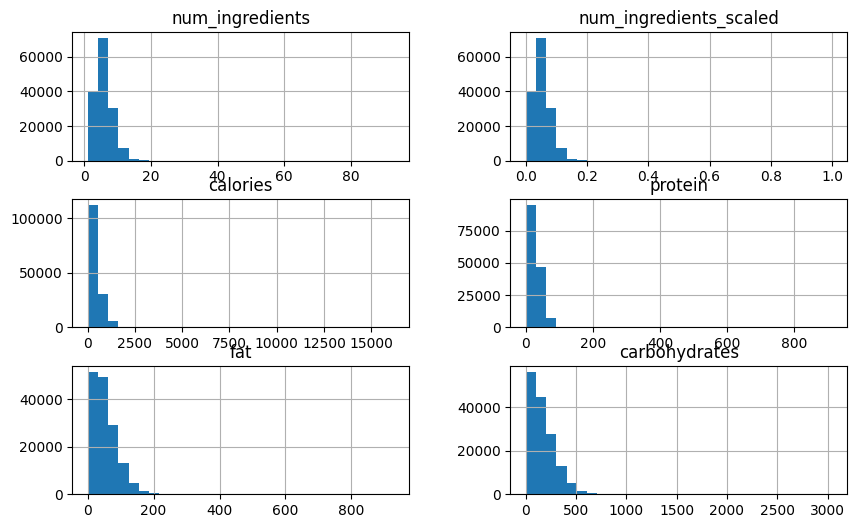

In [73]:
print(df.describe())
df.hist(figsize = (10, 6), bins = 30)
plt.show()

### Practical Consideration to Filtering

We need practical considerations to filtering the content of single meals.

In [74]:
# Take a practical approach; there are simply too many outliers
df = df[(df['calories'] > 100) & (df['calories'] < 4000)]
df = df[df['protein'] < 150]
df = df[df['fat'] < 150]
df = df[df['carbohydrates'] < 600] 
df = df[df['num_ingredients'] < 40]

       num_ingredients  num_ingredients_scaled      calories       protein  \
count     95664.000000            95664.000000  95664.000000  95664.000000   
mean          6.447723                0.059214    526.182075     30.437764   
std           2.433212                0.026448    303.903799     18.043958   
min           1.000000                0.000000    101.000000      0.000000   
25%           5.000000                0.043478    300.000000     16.580000   
50%           6.000000                0.054348    467.000000     28.300000   
75%           8.000000                0.076087    672.000000     41.860000   
max          29.000000                0.304348   2541.000000    148.740000   

                fat  carbohydrates  
count  95664.000000   95664.000000  
mean      57.279272     177.641073  
std       33.471587     120.672048  
min        0.000000       0.000000  
25%       32.140000      81.480000  
50%       53.450000     158.720000  
75%       79.600000     253.610000  
m

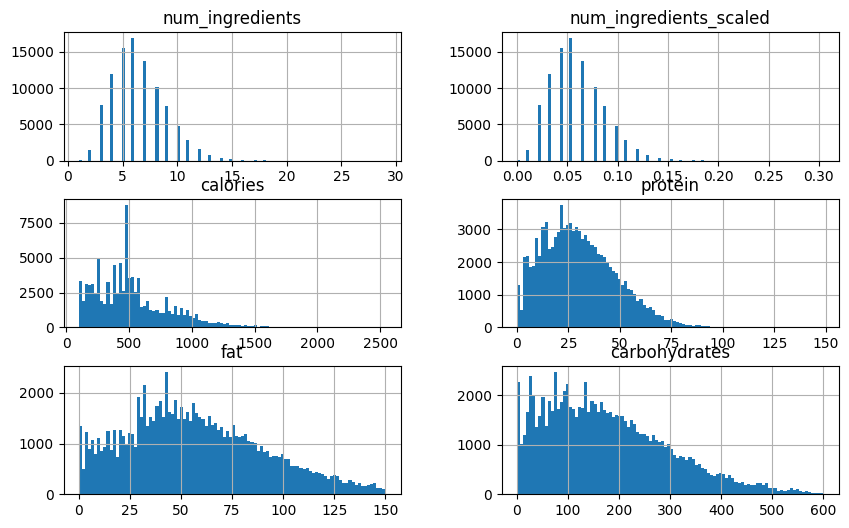

In [902]:
# Check distribution once more
print(df.describe())
df.hist(figsize = (10, 6), bins = 100)
plt.show()

### **Milestone 2: Bayesian Network**

##### Restart from here when testing Milestone 3

In [1020]:
bn_data = df[['title', 'num_ingredients', 'calories', 'protein', 'fat', 'carbohydrates']].copy()

print("\nChecking for null values:")
print(bn_data.isna().sum())

calorie_edges = [-np.inf, 150, 300, 450, 600, 750, 1000, 1500, np.inf]
protein_edges = [-np.inf, 5, 10, 15, 20, 30, 40, 50, 75, np.inf]
fat_edges = [-np.inf, 10, 20, 30, 40, 50, 75, 100, np.inf]
carb_edges = [-np.inf, 25, 50, 75, 100, 200, 300, 400, 500, np.inf]
ingredient_edges = [-np.inf, 3, 5, 7, 9, 11, np.inf]



Checking for null values:
title              0
num_ingredients    0
calories           0
protein            0
fat                0
carbohydrates      0
dtype: int64


In [1021]:
categories = ["calorie_category", "protein_category", "fat_category", "carb_category", "ingredient_category"]
columns = ["calories", "protein", "fat", "carbohydrates", "num_ingredients"]
edge_list = [calorie_edges, protein_edges, fat_edges, carb_edges, ingredient_edges]
units = [" kcal", " g", " g", " g", ""]

for category, column, edges, unit in zip(categories, columns, edge_list, units):
    curr_labels = []

    for i in range(len(edges) - 1):
        lower_bound = edges[i] if edges[i] != -np.inf else 0
        upper_bound = edges[i+1] if edges[i+1] != np.inf else None
        
        if upper_bound != None:
            curr_labels += [f"{lower_bound}-{upper_bound}{unit}"]
        else:
            curr_labels += [f"{lower_bound}+{unit}"]

    bn_data[category] = pd.cut(bn_data[column], bins = edges, labels = curr_labels)

In [1022]:
print("\nShowing how data is categorized now:")
print(bn_data[['title', 'calorie_category', 'protein_category', 'fat_category', 'carb_category', 'ingredient_category']].head())

print("\nChecking shape of bn_data")
print(bn_data.shape)


Showing how data is categorized now:
                                          title calorie_category  \
2                         Double Cherry Delight     150-300 kcal   
3              Eggless Milkless Applesauce Cake   1000-1500 kcal   
6                       Watermelon Rind Pickles     600-750 kcal   
9   Creamy Coleslaw(Better Homes And Gardens)      750-1000 kcal   
11                                Sausage Balls     300-450 kcal   

   protein_category fat_category carb_category ingredient_category  
2            5-10 g       0-10 g       25-50 g                 5-7  
3           30-40 g     75-100 g     300-400 g                 7-9  
6           20-30 g      30-40 g     100-200 g                 3-5  
9           50-75 g       100+ g     300-400 g                 7-9  
11            0-5 g       0-10 g      75-100 g                 0-3  

Checking shape of bn_data
(95664, 11)


In [1023]:
# Dropping original variables
title_col = bn_data.reset_index(drop = True)["title"]
bn_data = bn_data.drop(columns=['title', 'calories', 'protein', 'fat', 'carbohydrates', 'num_ingredients'])
bn_data.reset_index(drop = True, inplace = True)

# Checking data once more to verify
print(bn_data.head())

  calorie_category protein_category fat_category carb_category  \
0     150-300 kcal           5-10 g       0-10 g       25-50 g   
1   1000-1500 kcal          30-40 g     75-100 g     300-400 g   
2     600-750 kcal          20-30 g      30-40 g     100-200 g   
3    750-1000 kcal          50-75 g       100+ g     300-400 g   
4     300-450 kcal            0-5 g       0-10 g      75-100 g   

  ingredient_category  
0                 5-7  
1                 7-9  
2                 3-5  
3                 7-9  
4                 0-3  


In [1024]:
print("Calorie Category Distribution:")
print(bn_data["calorie_category"].value_counts())

print("\nProtein Category Distribution:")
print(bn_data["protein_category"].value_counts())

print("\nFat Category Distribution:")
print(bn_data["fat_category"].value_counts())

print("\nCarb Category Distribution:")
print(bn_data["carb_category"].value_counts())

print("\nIngredient Category Distribution:")
print(bn_data["ingredient_category"].value_counts())

print("\nMissing Values in Categorical Data:")
print(bn_data.isnull().sum())

Calorie Category Distribution:
calorie_category
450-600 kcal      24187
300-450 kcal      18937
150-300 kcal      18700
750-1000 kcal     12494
600-750 kcal       8389
1000-1500 kcal     6821
0-150 kcal         5333
1500+ kcal          803
Name: count, dtype: int64

Protein Category Distribution:
protein_category
20-30 g    21167
30-40 g    17730
40-50 g    12763
50-75 g    12427
10-15 g     9142
15-20 g     8789
5-10 g      6940
0-5 g       5224
75+ g       1482
Name: count, dtype: int64

Fat Category Distribution:
fat_category
50-75 g     23987
75-100 g    15885
40-50 g     11694
100+ g      11570
30-40 g     10999
20-30 g      7925
10-20 g      6821
0-10 g       6783
Name: count, dtype: int64

Carb Category Distribution:
carb_category
100-200 g    29439
200-300 g    20726
300-400 g    10272
75-100 g      8221
25-50 g       7568
50-75 g       7208
0-25 g        6948
400-500 g     4145
500+ g        1137
Name: count, dtype: int64

Ingredient Category Distribution:
ingredient_category


##### Checking Correlation between Features

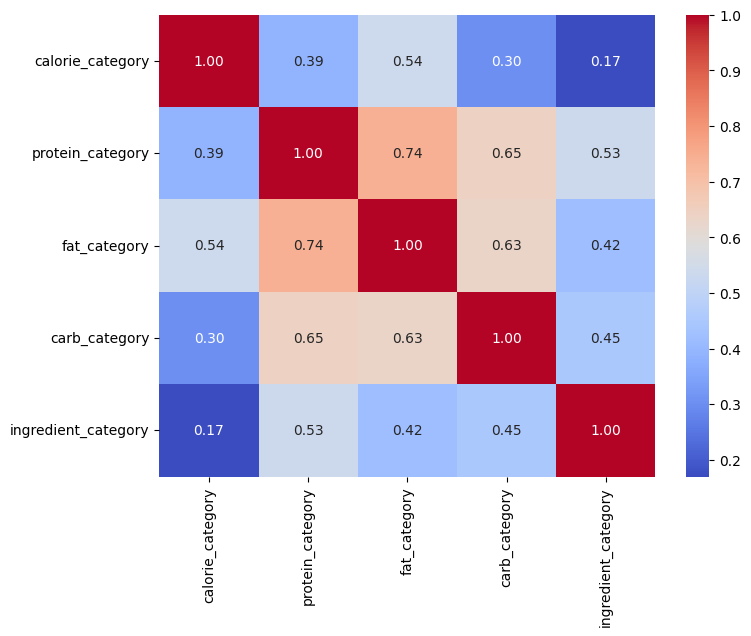

In [1025]:
# Convert categorical labels to numeric values for correlation check
bn_data_numeric = bn_data.copy()
for category in ["calorie_category", "protein_category", "fat_category", "carb_category", "ingredient_category"]:
    bn_data_numeric[category] = bn_data_numeric[category].astype("category").cat.codes

plt.figure(figsize=(8,6))
sns.heatmap(bn_data_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

### Training Bayesian Network with HillClimbSearch and K2 Scoring

In [1026]:
# Must explain in Readme file why it was necessary
hc = HillClimbSearch(bn_data)
best_model = hc.estimate(scoring_method=K2Score(bn_data))
bayesian_network = BayesianNetwork(best_model.edges())
bayesian_network.fit(bn_data, estimator=MaximumLikelihoodEstimator)

  0%|          | 11/1000000 [00:00<9:37:42, 28.85it/s]


In [1027]:
print("Ensuring that Bayesian Network is valid:")
print(bayesian_network.edges())

Ensuring that Bayesian Network is valid:
[('calorie_category', 'ingredient_category'), ('protein_category', 'fat_category'), ('protein_category', 'ingredient_category'), ('protein_category', 'calorie_category'), ('fat_category', 'calorie_category'), ('fat_category', 'ingredient_category'), ('carb_category', 'protein_category'), ('carb_category', 'calorie_category'), ('carb_category', 'fat_category'), ('carb_category', 'ingredient_category')]


In [1028]:
inference = VariableElimination(bayesian_network)

target = "750-1000 kcal"

if all(var in bayesian_network.nodes() for var in ["protein_category", "fat_category", "carb_category", "calorie_category", "ingredient_category"]):
    query_result_multi = inference.query(variables=["protein_category", "fat_category", "carb_category", "ingredient_category"], evidence={"calorie_category": f"{target}"})
    max_index = query_result_multi.values.argmax()
    max_prob = query_result_multi.values.max()

    prob_indices = np.unravel_index(max_index, query_result_multi.values.shape)

    prob_protein = query_result_multi.state_names["protein_category"][prob_indices[0]]
    prob_fat = query_result_multi.state_names["fat_category"][prob_indices[1]]
    prob_carb = query_result_multi.state_names["carb_category"][prob_indices[2]]
    prob_ingredients = query_result_multi.state_names["ingredient_category"][prob_indices[3]]

    print("\nMost probable (Protein, Fat, Carb, Ingredients) recommendation given query:")
    print(f"Protein = {prob_protein}, Fat = {prob_fat}, Carbs = {prob_carb}, Ingredients = {prob_ingredients} (P={max_prob:.4f})")


Most probable (Protein, Fat, Carb, Ingredients) recommendation given query:
Protein = 50-75 g, Fat = 100+ g, Carbs = 400-500 g, Ingredients = 7-9 (P=0.0223)


### Bayesian Network Graph

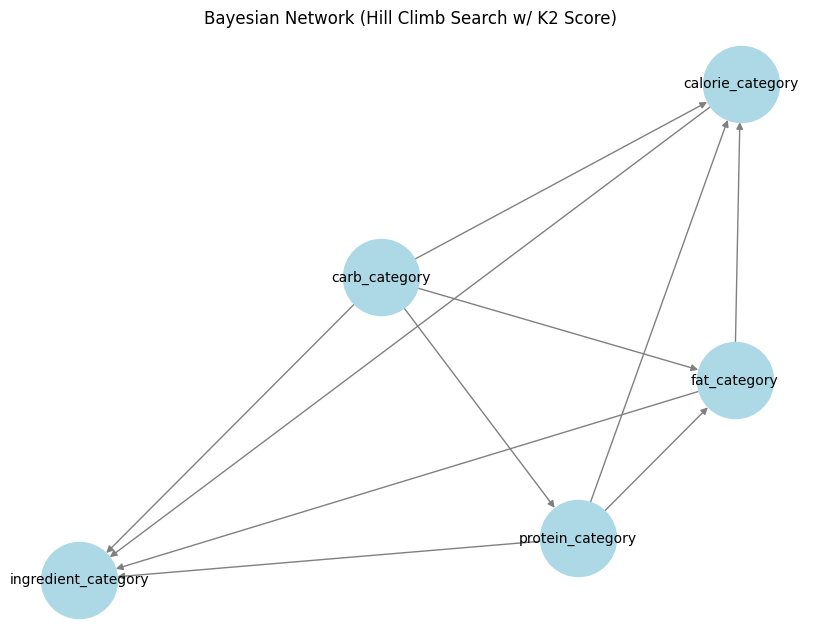

Learned Bayesian Network Edges:
calorie_category to ingredient_category
protein_category to fat_category
protein_category to ingredient_category
protein_category to calorie_category
fat_category to calorie_category
fat_category to ingredient_category
carb_category to protein_category
carb_category to calorie_category
carb_category to fat_category
carb_category to ingredient_category


In [1029]:
# Bayesian Neywork: Hill Climb Search
plt.figure(figsize=(8, 6))
G = nx.DiGraph(bayesian_network.edges())

# Seed is set for repeatability
pos = nx.spring_layout(G, seed = 25)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", 
        node_size=3000, font_size=10, arrows=True)

plt.title("Bayesian Network (Hill Climb Search w/ K2 Score)")
plt.show()

print("Learned Bayesian Network Edges:")
for edge in bayesian_network.edges():
    print(f"{edge[0]} to {edge[1]}")


### **Milestone 3: Hidden Markov Model**

In [1030]:
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder

In [1031]:
def bin_to_numeric(bin_str):
    try:
        numbers = [int(num) for num in bin_str.split()[0].split('-')]
        return (numbers[1] - numbers[0]) / 2 + numbers[0]
    except:
        try:
            token = bin_str.split()[0]
            if "+" in token:
                num = int(token.replace('+', ''))
                return float(num)
        except:
            return np.nan

##### User-oriented direction; simulated content for demonstration purposes

In [1032]:
user_data = pd.DataFrame()
np.random.seed(2003)
user_data["satisfaction"] = np.random.uniform(0.7, 1, len(bn_data))
user_data["diet_adherence"] = np.random.uniform(0.7, 1, len(bn_data))


bn_data_temp = bn_data
convert_cols = ["calorie_category", "protein_category", "fat_category", "carb_category", "ingredient_category"]

for col in convert_cols:
    bn_data_temp[col] = bn_data_temp[col].apply(bin_to_numeric)

user_data = pd.concat([user_data, bn_data_temp], axis = 1)

In [1033]:
print(user_data.head())

   satisfaction  diet_adherence calorie_category protein_category  \
0      0.847687        0.845815            225.0              7.5   
1      0.833678        0.785187           1250.0             35.0   
2      0.821539        0.866935            675.0             25.0   
3      0.803918        0.982925            875.0             62.5   
4      0.954125        0.810742            375.0              2.5   

  fat_category carb_category ingredient_category  
0          5.0          37.5                 6.0  
1         87.5         350.0                 8.0  
2         35.0         150.0                 4.0  
3        100.0         350.0                 8.0  
4          5.0          87.5                 1.5  


In [1034]:
metrics = [col for col in user_data.columns if col != "predicted_behavior"]
data_scaler = MinMaxScaler()
user_data[metrics] = scaler.fit_transform(user_data[metrics])

In [1035]:
# Viewing scaled dataset
print(user_data.head())

   satisfaction  diet_adherence  calorie_category  protein_category  \
0      0.492293        0.486046          0.105263          0.068966   
1      0.445596        0.283949          0.824561          0.448276   
2      0.405130        0.556448          0.421053          0.310345   
3      0.346395        0.943084          0.561404          0.827586   
4      0.847089        0.369136          0.210526          0.000000   

   fat_category  carb_category  ingredient_category  
0      0.000000       0.051282             0.473684  
1      0.868421       0.692308             0.684211  
2      0.315789       0.282051             0.263158  
3      1.000000       0.692308             0.684211  
4      0.000000       0.153846             0.000000  


In [1036]:
weights = {
    "satisfaction" : 0.25, # Important for user input
    "diet_adherence" : 0.3, # Important for user input
    "ingredient_category" : 0.2, # Simple: num_ingredients cost proxy
    "protein_category" : 0.5, # Simple: protein good
    "fat_category" : 0.1, # Simple: fat ok
    "carb_category" : -0.5, # Simple: carbs bad
    "calorie_category" : 0.3 # Simple: calories still important
}

user_data["score"] = sum(weights[category] * user_data[category] for category in metrics)

observations = user_data["score"].values.reshape(-1, 1)

In [1037]:
model = hmm.GaussianHMM(n_components = 3, n_iter = 100, random_state = 101)
# model.startprob_ = np.array([1/3, 1/3, 1/3]) # Similar to forward inference
model.fit(observations)
predicted_labels = model.predict(observations)
user_data["predicted_behavior"] = predicted_labels

In [1038]:
state_means = user_data.groupby("predicted_behavior")["score"].mean().sort_values(ascending=False)
mapping = {}
sorted_states = state_means.index.tolist()
print(sorted_states)

[1, 2, 0]


In [1039]:
mapping[sorted_states[0]] = "Healthy"
mapping[sorted_states[1]] = "Normal"
mapping[sorted_states[2]] = "Unhealthy"
user_data["adherence"] = user_data["predicted_behavior"].map(mapping)
user_data.drop(columns = ["predicted_behavior"])
user_data.insert(0, "title", title_col)

In [1040]:
# Print a sample of the results
print(user_data["adherence"].value_counts())
print(user_data[["title", "score", "adherence"]].head())

adherence
Unhealthy    41307
Normal       41122
Healthy      13235
Name: count, dtype: int64
                                         title     score  adherence
0                        Double Cherry Delight  0.404044  Unhealthy
1             Eggless Milkless Applesauce Cake  0.545621     Normal
2                      Watermelon Rind Pickles  0.492890  Unhealthy
3  Creamy Coleslaw(Better Homes And Gardens)    0.842426     Normal
4                                Sausage Balls  0.308748  Unhealthy


In [1041]:
column_categories = ["calorie_category", "protein_category", "fat_category", "carb_category",
                     "ingredient_category"]

# Re-fit a scaler only on these 5 columns from the original bn_data
subset_scaler = MinMaxScaler()
subset_scaler.fit(bn_data[column_categories])

grouped_means = user_data.groupby("adherence")[column_categories].mean()

original_stats = pd.DataFrame(subset_scaler.inverse_transform(grouped_means),
                              index=grouped_means.index,
                              columns=grouped_means.columns)

print(original_stats)

           calorie_category  protein_category  fat_category  carb_category  \
adherence                                                                    
Healthy          774.304873         46.335096     74.790706     196.765206   
Normal           536.063421         31.282586     56.141603     179.901877   
Unhealthy        446.429782         25.309088     48.252475     173.449415   

           ingredient_category  
adherence                       
Healthy               7.262637  
Normal                5.896163  
Unhealthy             5.334374  


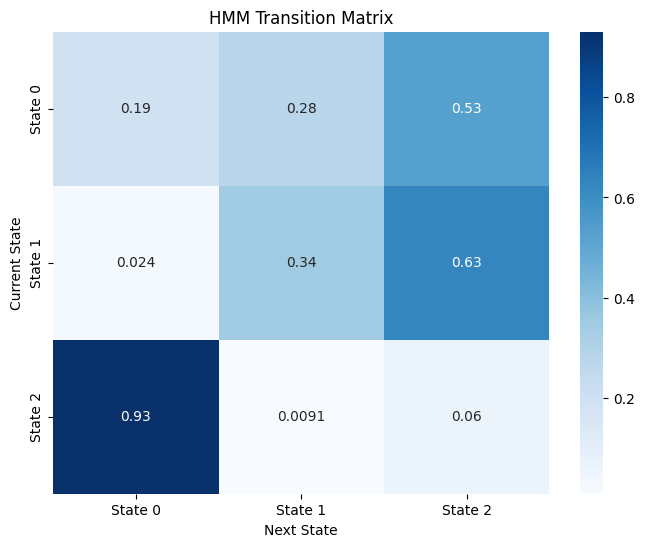

In [1042]:
trans_mat = model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(trans_mat, annot=True, cmap="Blues", 
            xticklabels=[f"State {i}" for i in range(trans_mat.shape[1])],
            yticklabels=[f"State {i}" for i in range(trans_mat.shape[0])])
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.title("HMM Transition Matrix")
plt.show()